<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# RNN Exercises
For these exercises we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N

In the exercises below you'll be asked to do the following:
* Perform standard imports, load & plot the dataset (code provided)
* Prepare data for an LSTM model
* Define the LSTM model, loss and optimization functions
* Train the model
* Evaluate the model on test data
* OPTIONAL: Plot the results

<div class="alert alert-danger" style="margin: 10px"><strong>IMPORTANT NOTE!</strong> Make sure you don't run the cells directly above the example output shown, <br>otherwise you will end up writing over the example output!</div>

## Perform standard imports, load and plot the dataset
Run the cells below to load the libraries needed for this exercise and the Energy Production dataset, and to plot the data.

In [1]:
# RUN THIS CELL
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('../Data/TimeSeriesData/Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


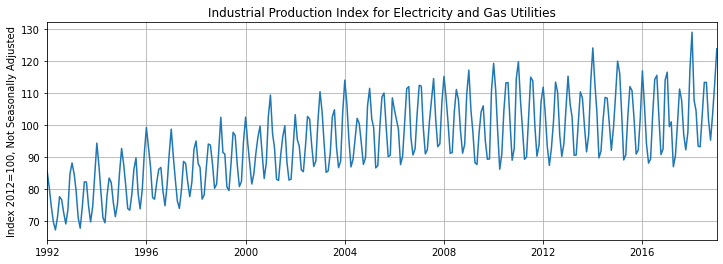

In [2]:
# RUN THIS CELL
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

# Prepare the data
For the first set of exercises we'll
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

## 1. Divide the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [3]:
# CODE HERE
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12 

train_set = y[:-12]
test_set = y[-12:]

In [4]:
# Run the code below to check your results:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


In [5]:
# DON'T WRITE HERE

## 2. Normalize the training set
Feature scale the training set to fit within the range [-1,1].

In [6]:
# CODE HERE
scaler = MinMaxScaler(feature_range=(-1, 1))


train_norm = scaler.fit_transform(train_set.reshape(-1,1))

In [7]:
# Run the code below to check your results:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 85.556
First item, scaled:  [-0.4091274]


In [8]:
# DON'T WRITE HERE

## 3. Prepare data for LSTM
Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [9]:
# RUN THIS CELL
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [10]:
# CODE HERE

train_data = input_data(train_norm,window_size)

In [11]:
# Run the code below to check your results:
print(f'Train_data: {len(train_data)}')  # should equal 301

Train_data: 301


In [12]:
# DON'T WRITE HERE

## 4. Define the model
Design a model that has a (1,64) LSTM layer and a (64,1) fully-connected linear layer. Be sure to initialize $h_0$ and $c_0$, and return only the last predicted value.

In [13]:
help(nn.LSTM)

Help on class LSTM in module torch.nn.modules.rnn:

class LSTM(RNNBase)
 |  LSTM(*args, **kwargs)
 |  
 |  Applies a multi-layer long short-term memory (LSTM) RNN to an input
 |  sequence.
 |  
 |  
 |  For each element in the input sequence, each layer computes the following
 |  function:
 |  
 |  .. math::
 |      \begin{array}{ll} \\
 |          i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
 |          f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
 |          g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
 |          o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
 |          c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
 |          h_t = o_t \odot \tanh(c_t) \\
 |      \end{array}
 |  
 |  where :math:`h_t` is the hidden state at time `t`, :math:`c_t` is the cell
 |  state at time `t`, :math:`x_t` is the input at time `t`, :math:`h_{t-1}`
 |  is the hidden state of the layer at time `t-1` or the initial hidden
 |  state a

In [14]:
# CODE HERE
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size = 64,output_size = 1):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size)
        
        self.linear = nn.Linear(hidden_size,output_size)
        
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
        
    def forward(self,x_0):
        x_1,self_hidden = self.lstm(x_0.view(len(x_0),1,-1),self.hidden)
        x_2 = self.linear(x_1.view(len(x_0),-1))
        return x_2[-1]
        
        
  

In [15]:
# Run the code below to check your results:
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [16]:
# DON'T WRITE HERE

## 5. Define loss and optimization functions
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used MSELoss and Adam (learning rate of 0.001) respectively.

In [17]:
# CODE HERE
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)


In [18]:
# DON'T WRITE HERE

### 6. Train the model
Don't worry about tracking loss values, displaying results, or validating the test set. Just train the model through 50 epochs. We'll evaluate the trained model in the next step.<br>
OPTIONAL: print something after each epoch to indicate training progress.

In [19]:
# CODE HERE
epochs = 100

for epoch in range(epochs):
    
    for seq,y_test in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros_like(model.hidden[0]),torch.zeros_like(model.hidden[1]))
        
        predictions = model(seq)
        loss = criterion(predictions,y_test)
        
        loss.backward()
        optimizer.step()
    print("Epoch {} completed".format(epoch))


Epoch 0 completed
Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed
Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed
Epoch 30 completed
Epoch 31 completed
Epoch 32 completed
Epoch 33 completed
Epoch 34 completed
Epoch 35 completed
Epoch 36 completed
Epoch 37 completed
Epoch 38 completed
Epoch 39 completed
Epoch 40 completed
Epoch 41 completed
Epoch 42 completed
Epoch 43 completed
Epoch 44 completed
Epoch 45 completed
Epoch 46 completed
Epoch 47 completed
Epoch 48 completed
Epoch 49 completed
Epoch 50 completed
Epoch 51 completed
Epoch 52 completed
Epo

In [20]:
# DON'T WRITE HERE

### 9. Evaluate the model using the test set
Be sure to re-initialize the hidden parameters $h_0$ and $c_0$ before running the model.

In [34]:
# CODE HERE
future = 24
preds = train_data[-1][0].tolist()

model.eval()

for i in range(future):
    optimizer.zero_grad()
    model.hidden = (torch.zeros_like(model.hidden[0]),torch.zeros_like(model.hidden[1]))

    prediction = model(torch.tensor(preds[-future:]))
    preds.append(prediction.item())

In [35]:
# Run the code below to check your results:
preds[window_size:]

[0.8952453136444092,
 0.3105928897857666,
 0.08955645561218262,
 -0.2684399485588074,
 -0.12519384920597076,
 0.3407228887081146,
 0.40618959069252014,
 0.1408548504114151,
 -0.059926338493824005,
 -0.3211089074611664,
 -0.15715350210666656,
 0.20410841703414917,
 0.5944093465805054,
 0.529393196105957,
 0.2498784363269806,
 -0.21239766478538513,
 -0.1322249323129654,
 0.4640149474143982,
 0.4867834448814392,
 0.11663030833005905,
 -0.020953267812728882,
 -0.3953530192375183,
 -0.2726061940193176,
 -0.015528619289398193]

In [36]:
# DON'T WRITE HERE

## 10. Inverse transform the predicted values
Rescale the predicted values up to the original test set range.

In [37]:
# CODE HERE
true_predictions = scaler.inverse_transform(torch.tensor(preds[window_size:]).reshape(-1,1))

In [38]:
# Run the code below to check your results:
true_predictions

array([[125.68437445],
       [107.69783496],
       [100.89775958],
       [ 89.8841792 ],
       [ 94.29107383],
       [108.62476931],
       [110.63881966],
       [102.47592905],
       [ 96.29899616],
       [ 88.26384502],
       [ 93.30785108],
       [104.4218934 ],
       [116.42930634],
       [114.42911698],
       [105.82998515],
       [ 91.60829204],
       [ 94.07476607],
       [112.41778785],
       [113.11824929],
       [101.73067312],
       [ 97.49798319],
       [ 85.97976204],
       [ 89.75600674],
       [ 97.66486979]])

In [39]:
# DON'T WRITE HERE

## BONUS EXERCISE: Plot the result
Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

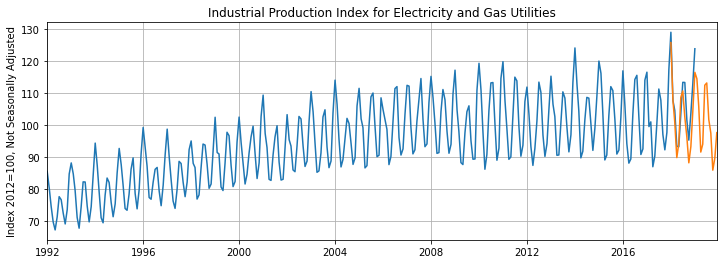

In [40]:
# CODE HERE
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(np.arange("2018-01-01","2020-01-01",dtype="datetime64[M]").astype("datetime64[D]"),true_predictions)
plt.show()

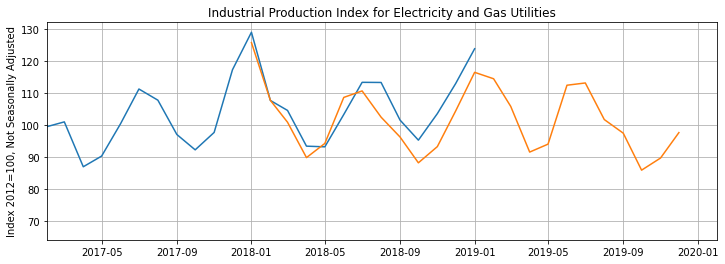

In [42]:
# CODE HERE TO DISPLAY THE END OF THE GRAPH
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(np.arange("2018-01-01","2020-01-01",dtype="datetime64[M]").astype("datetime64[D]"),true_predictions)
plt.xlim(("2017-02-01","2020-02-01"))
plt.show()

In [29]:
# DON'T WRITE HERE

In [30]:
# DON'T WRITE HERE

## Great job!